## Setting Up

In [3]:
import sys
sys.path.append('../src')

In [4]:
import os
import numpy as np
import copy
import json
from pymatreader import read_mat

In [5]:
dataset_path = "../data/raw"
image_files_path = "../data/raw/original_images"

In [6]:
data = read_mat(f'{dataset_path}/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')
data = data['RELEASE']

In [7]:
id_joint = {0: 'rankl', 1: 'rknee', 2: 'rhip',  3: 'lhip', 4: 'lknee', 5: 'lankl',
                   6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 9: 'head_top', 10: 'rwri', 11: 'relb',
                   12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'} # id to joint conversion

In [8]:
skeleton_data = [
        [0, 1], # right_ankle right_knee
        [1, 2], # right_knee right_hip
        [2, 6], # right_hip pelvis
        [6, 3], # pelvis left_hip
        [3, 4], # left_hip left_knee
        [4, 5], # left_knee left_ankle
        [12, 11], # right_shoulder right_elbow
        [11, 10], # right_elbow right_wrist
        [13, 14], # left_shoulder left_elbow
        [14, 15], # left_elbow left_wrist
        [2, 12], # right_hip right_shoulder
        [3, 13], # left_hip left_shoulder
        [2, 7], # right_hip right_thorax
        [3, 7], # left_hip thorax
        [12, 7], # right_shoulder thorax
        [13, 7], # left_shoulder thorax,
        [7, 8], # thorax upper_neck
        [8, 9], # upper_neck head_top
    ]

In [9]:
id = [i for i in range(16)]
id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [10]:
num_images = len(data['annolist']['image'])
num_images

24987

## Extracting the valid data

In [11]:
from data.data_cleaner import extract_valid_data_from_matlab_file

In [12]:
valid_annot_data = extract_valid_data_from_matlab_file(data, id, num_images, f'{image_files_path}')

[+] Img_name: 089482735.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 077224477.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 077224477.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 077224477.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 077096718.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 011986537.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 030087831.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 031897563.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 081446848.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 069673717.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 082645747.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 008483771.jpg has a negative keypoint co-ordinates, its handled.
[+] Img_name: 008483771.jpg has a negative keypoint 

In [13]:
from utilities.utils import open_file
from utilities.utils import clear_files_in_directory
from utilities.utils import rescale_and_save_image
from utilities.utils import write_data_if_file_not_exists
from utilities.utils import randPlotImage

In [14]:
processed_dataset_path = '../data/processed'

Checking if processed data already exists...

In [15]:
doesModifiedDataExist = False
if os.path.exists(f'{processed_dataset_path}/resized_annotations_data.json'):
    valid_annot_data = open_file(f'{processed_dataset_path}/resized_annotations_data.json')
    doesModifiedDataExist = True
    print("[+] Path does exist...")
else:
    print("[-] Path does not exist...")

[+] Path does exist...


If processed data does not exist, clearing the other data(if any) in the respective directories

In [16]:
if not doesModifiedDataExist:
    clear_files_in_directory(f'{processed_dataset_path}/images')
    clear_files_in_directory(f'{processed_dataset_path}/images/train')
    clear_files_in_directory(f'{processed_dataset_path}/images/val')
    clear_files_in_directory(f'{processed_dataset_path}/labels/train')
    clear_files_in_directory(f'{processed_dataset_path}/labels/val')

In [17]:
dataset_path, processed_dataset_path, image_files_path

('../data/raw', '../data/processed', '../data/raw/original_images')

Rescaling each image to (480, 640) and saving it to /data/processed/images/image_name, and corresponding annotation to <br>
/data/processed/resized_annotations_data.json

In [18]:
# Iterate over each image and rescale it and then overwrite it
# Below code may take upto 3min sec to run

if not doesModifiedDataExist:
    for i in range(len(valid_annot_data)):
        file_path = f'{image_files_path}/' + valid_annot_data[i]['name']
        file_path_write = f'{processed_dataset_path}/images/' + valid_annot_data[i]['name']
        image_indx = i
        # print(f"[+] Indx: {image_indx}")
        rescale_and_save_image(file_path, file_path_write, valid_annot_data, image_indx, (480, 640))
        
    write_data_if_file_not_exists(f'{processed_dataset_path}/resized_annotations_data.json', valid_annot_data)
    doesModifiedDataExist = True

In [ ]:
## Handling the beyond resolution images

In [19]:
image_height = 480
image_width = 640

Some entries are invalid i.e their x >= image_width or y >= image_height, replace as (x, y, visibility) = (0, 0, 0)

In [20]:
# Some entries are invalid i.e their x >= image_width or y >= image_height
# Filtering invalid values
for i in range(len(valid_annot_data)):
    for j in range(len(valid_annot_data[i]["personInfo"])):
        for k in range(len(valid_annot_data[i]["personInfo"][j]["x"])):
            if (valid_annot_data[i]["personInfo"][j]["x"][k] > image_width) or (valid_annot_data[i]["personInfo"][j]["y"][k] > image_height):
                valid_annot_data[i]["personInfo"][j]["x"][k] = 0
                valid_annot_data[i]["personInfo"][j]["y"][k] = 0

In [21]:
normalise_flag = False

Normalising the annotations, i.e, (x, y) is reduced to 0 <= x <= 1, 0 <= y <= 1

In [22]:
# Normalise the image annotations
if not normalise_flag:
    for i in range(len(valid_annot_data)):
        for j in range(len(valid_annot_data[i]["personInfo"])):
            # Normalise the head rectangle co-ordinates
            valid_annot_data[i]["personInfo"][j]['x1'] = (valid_annot_data[i]["personInfo"][j]['x1'] * 1.0) / image_width
            valid_annot_data[i]["personInfo"][j]['x2'] = (valid_annot_data[i]["personInfo"][j]['x2'] * 1.0) / image_width

            valid_annot_data[i]["personInfo"][j]['y1'] = (valid_annot_data[i]["personInfo"][j]['y1'] * 1.0) / image_height
            valid_annot_data[i]["personInfo"][j]['y2'] = (valid_annot_data[i]["personInfo"][j]['y2'] * 1.0) / image_height

            # Normalise the keypoints to between 0 and 1
            valid_annot_data[i]["personInfo"][j]['x'] = (np.array(valid_annot_data[i]["personInfo"][j]['x']))
            valid_annot_data[i]["personInfo"][j]['y'] = (np.array(valid_annot_data[i]["personInfo"][j]['y']))

            valid_annot_data[i]["personInfo"][j]['x'] = (valid_annot_data[i]["personInfo"][j]['x'].astype(float)) / image_width
            valid_annot_data[i]["personInfo"][j]['y'] = (valid_annot_data[i]["personInfo"][j]['y'].astype(float)) / image_height
    normalise_flag = True
else:
    print("[-] Already ran once, can't run again")

In [25]:
normalise_flag

True

For feeding the data to yolov8 nano, visibility can have 3 possible values<br>
is_visible:<br>
0 -> not labelled<br>
1 -> labelled but not visible<br>
2 -> labelled and visible<br>
<br>
For images with x==0 and y==0 we make visibility==0, we make it as: (x, y, visibility) = (0, 0, 0)<br>
For images with x>0 and y>0 if we visibility==0, we make it as: (x, y, visibility) = (x, y, 1)<br>
For images with x>0 and y>0 if we visibility==1, we make it as: (x, y, visibility) = (x, y, 2)<br>

In [26]:
for i in range(len(valid_annot_data)):
    for j in range(len(valid_annot_data[i]["personInfo"])):
        for k in range(len(valid_annot_data[i]["personInfo"][j]['x'])):
            if valid_annot_data[i]["personInfo"][j]['x'][k] == 0:
                valid_annot_data[i]["personInfo"][j]['is_visible'][k] = 0
            else:
                if (valid_annot_data[i]["personInfo"][j]['is_visible'][k] == 0):
                    valid_annot_data[i]["personInfo"][j]['is_visible'][k] = 1
                else:
                    valid_annot_data[i]["personInfo"][j]['is_visible'][k] = 2

## Visualising the data

[+] Choice: 8866, num_person: 1 image:095541416.jpg with shape (480, 640, 3)
<class 'numpy.int64'>


'095541416.jpg'

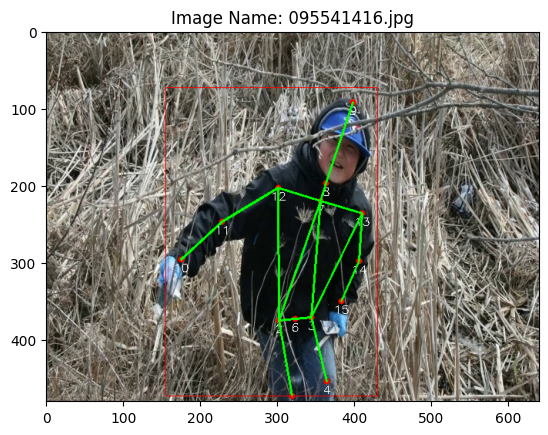

In [28]:
randPlotImage(valid_annot_data, skeleton_data, processed_dataset_path, 'images', image_width, image_height, image_height, image_width)

## Save the normalised annotations

<h3> Randomise/shuffle the data before saving it <h3>

In [98]:
import random

In [100]:
random.shuffle(valid_annot_data)

In [102]:
processed_dataset_path

'../data/processed'

In [114]:
does_norm_data_exist = os.path.isfile(f"{processed_dataset_path}/normalised_annot_data.json")
does_norm_data_exist

True

In [113]:
if not does_norm_data_exist:
    save_data = copy.deepcopy(valid_annot_data)
    print("[+] Created a deepcopy of the annotations....s")
else:
    print("[+] Directory structure has already been created...")

[+] Directory structure has already been created...


In [112]:
if not does_norm_data_exist: 
    for i in range(len(save_data)):
        for j in range(len(save_data[i]["personInfo"])):
            save_data[i]["personInfo"][j]['x'] = save_data[i]["personInfo"][j]['x'].tolist()
            save_data[i]["personInfo"][j]['y'] = save_data[i]["personInfo"][j]['y'].tolist()
else:
    print("[+] File already exists...")

[+] File already exists...


In [111]:
# Save the normalise data if not exists
if not does_norm_data_exist:
    try:
        with open(f"{processed_dataset_path}/normalised_annot_data.json", 'w') as f:
            json.dump(save_data, f, indent=4)  # Indent for readability
            print("[+] JSON data saved successfully to: ", f"{processed_dataset_path}/normalised_annot_data.json")
        does_norm_data_exist = True
    except Exception as e:
        print("Failed to save JSON data:", e)
else:
    print("[+] File already exists...")

[+] Directory structure has already been created...


In [110]:
does_norm_data_exist

True